![](https://img.shields.io/badge/CNES_AVISO-Contribution-%20?color=grey&labelColor=blue)


# Subset SWOT LR L2 Unsmoothed
This notebooks explains how to retrieve a geographical subset of unsmoothed (250-m) SWOT LR L2 data on AVISO's THREDDS Data Server.

L2 Unsmoothed data can be explored at:

* https://tds.aviso.altimetry.fr/thredds/catalog/dataset-l2-swot-karin-lr-ssh-pre-validated/PGC0/Unsmoothed/catalog.html
* https://tds.aviso.altimetry.fr/thredds/catalog/dataset-l2-swot-karin-lr-ssh-pre-validated/PIC0/Unsmoothed/catalog.html

You need to have xarray, numpy, pydap, threddsclient and matplotlib+cartopy (for visualisation) packages installed in your Python environment for this notebook to work.


## Tutorial Objectives
* Request Aviso's Thredds Data Server catalogue to find unsmoothed products
* Define a geographical area and temporal period to subset data
* Download data locally and visualise it



## Import + code



In [1]:
# Install Cartopy with mamba to avoid discrepancies
# ! mamba install -q -c conda-forge cartopy

In [2]:
import os
from getpass import getpass
import threddsclient
import numpy as np
import xarray as xr
from xarray.backends import PydapDataStore
import requests as rq
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [3]:
def retrieve_matching_datasets(url_catalogue, cycle_min, cycle_max, half_orbits):
    """ Returns the list of datasets available in the catalogue, matching required half_orbits and cycles range.
    Args:
        url_catalogue
        cycle_min
        cycle_max
        half_orbits

    Returns:
        The list of matching dataset nodes.
    """
    return list(filter(
        lambda dataset: (
            int(dataset.name[30:33]) in half_orbits and
            int(dataset.name[26:29]) >= cycle_min and
            int(dataset.name[26:29]) <= cycle_max),
        threddsclient.crawl(url_catalogue, depth=2)))

def open_dataset(dataset_url):
    """ Open the dataset at dataset_url.
    Args:
        dataset_url

    Returns:
        xr.Dataset
    """
    session = rq.Session()
    session.auth = (username, password)
    store = PydapDataStore.open(dataset_url, session=session, timeout=300, user_charset='UTF-8')
    return xr.open_dataset(store)

def _open_dataset_coords(dataset_url):
    positions_url = dataset_url + '?' + ','.join(["/left/latitude", "/left/longitude", "/right/latitude", "/right/longitude"])
    ds_coords = open_dataset(positions_url)
    return ds_coords

def _get_indexes(ds, lon_range, lat_range):
    mask_left = ((ds["/left/longitude"] >= lon_range[0]) & (ds["/left/longitude"] <= lon_range[1]) &
    (ds["/left/latitude"] >= lat_range[0]) & (ds["/left/latitude"] <= lat_range[1]))
            
    mask_right = ((ds["/right/longitude"] >= lon_range[0]) & (ds["/right/longitude"] <= lon_range[1]) & 
    (ds["/right/latitude"] >= lat_range[0]) & (ds["/right/latitude"] <= lat_range[1]))

    mask = (mask_left | mask_right).any('num_pixels')

    return np.where(mask)[0][0], np.where(mask)[0][-1] 

def _build_dataset_groups(ds, left_vars, right_vars, attrs):
    # Clean group EXTRA_DIMENSION and variable attributes from global attributes
    attributes = dict(filter(
        lambda item: (
            item[0] not in ["_NCProperties"] and
            f"/left/" not in item[0] and
            f"/right/" not in item[0] and
            "EXTRA_DIMENSION" not in item[0]),
        attrs.items()))
    
    ds_left = ds[left_vars]
    ds_left.attrs.clear()
    ds_left.attrs["description"] = attributes.pop("left_description")
    ds_left = ds_left.rename({v: v.removeprefix('/left/') for v in left_vars})
    
    ds_right = ds[right_vars]
    ds_right.attrs.clear()
    ds_right.attrs["description"] = attributes.pop("right_description")
    ds_right = ds_right.rename({v: v.removeprefix('/right/') for v in right_vars})
    
    ds_root = ds[[]]
    ds_root.attrs = attributes

    return ds_root, ds_left, ds_right

def to_netcdf(ds_root, ds_left, ds_right, output_file):
    """ Writes the dataset to a netcdf file """
    ds_root.to_netcdf(output_file)
    ds_right.to_netcdf(output_file, group='right', mode='a')
    ds_left.to_netcdf(output_file, group='left', mode='a')
    
def _output_dir_prompt():
    answer = input('Do you want to write results to Netcdf files? [y/n]')
    if not answer or answer[0].lower() != 'y':
        return None
    return input('Enter existing directory:')
    
def load_subsets(matching_datasets, variables, lon_range, lat_range, output_dir=None):
    """ Loads subsets with variables and lon/lat range, and eventually write them to disk.
    Args:
        matching_datasets : the datasets nodes in the catalogue
        variables : the variables names
        lon_range : the longitude range
        lat_range : the latitude range
        output_dir : the output directory to write the datasets in separated netcdf files

    Returns:
        xr.Dataset
    """
    if not output_dir:
        output_dir = _output_dir_prompt()

    left_vars = [f'/left/{v}' for v in variables]
    right_vars = [f'/right/{v}' for v in variables]

    return [dataset for dataset in [_load_subset(dataset, left_vars, right_vars, lon_range, lat_range, output_dir) for dataset in matching_datasets] if dataset is not None]
    
def _load_subset(dataset_node, left_vars, right_vars, lon_range, lat_range, output_dir=None):
    if output_dir:
        output_file = os.path.join(output_dir, f"subset_{dataset_node.name}")
        if os.path.exists(output_file):
            print(f"Subset {dataset_node.name} already exists. Reading it...")
            return xr.open_dataset(output_file)
            
    # Open the dataset only with coordinates
    dataset_url = dataset_node.opendap_url()
    ds_positions = _open_dataset_coords(dataset_url)

    # Locate indexes of lines matching with the required geographical area
    try:
        idx_first, idx_last = _get_indexes(ds_positions, lon_range, lat_range)
    except IndexError:
        print(f'No pass intersection with selected area for dataset {dataset_node.name}')
        return None
        
    print(f"Indices for dataset {dataset_node.name}: ({idx_first}, {idx_last})")

    # Download subset    
    dataset = open_dataset(dataset_url)
        
    ds = xr.merge([dataset[var][idx_first:idx_last] for var in left_vars+right_vars])
    ds.load()
    print(f"{dataset_node.name} subset loaded.")

    if output_file:
        ds_root, ds_left, ds_right = _build_dataset_groups(ds, left_vars, right_vars, ds_positions.attrs)
        to_netcdf(ds_root, ds_left, ds_right, output_file)
        print(f"{output_file} created.")
        
    return ds

def _interpolate_coords(ds):
    lon = ds.longitude
    lat = ds.latitude
    shape = lon.shape
    lon = np.array(lon).ravel()
    lat = np.array(lat).ravel()
    dss = xr.Dataset({
        'longitude': xr.DataArray(
                    data   = lon,
                    dims   = ['time']
                    ),
        'latitude': xr.DataArray(
                    data   = lat,
                    dims   = ['time'],
                    )
                },)
    dss_interp = dss.interpolate_na(dim="time", method="linear", fill_value="extrapolate")
    ds['longitude'] = (('num_lines', 'num_pixels'), dss_interp.longitude.values.reshape(shape))
    ds['latitude'] = (('num_lines', 'num_pixels'), dss_interp.latitude.values.reshape(shape))
    
def normalize_coordinates(ds):
    """ Normalizes the coordinates of the dataset : interpolates Nan values in lon/lat, and assign lon/lat as coordinates.
    Args:
        ds: the dataset

    Returns:
        xr.Dataset: the normalized dataset
    """
    _interpolate_coords(ds)
    return ds.assign_coords(
            {"longitude": ds.longitude, "latitude": ds.latitude}
        )

## Parameters



### Data parameters
Variables available in unsmoothed Swot LR data are:

time, time_tai, latitude, longitude, latitude_uncert, longitude_uncert, polarization_karin, ssh_karin_2, ssh_karin_2_qual, ssh_karin_uncert, sig0_karin_2, sig0_karin_2_qual, sig0_karin_uncert, total_coherence, mean_sea_surface_cnescls, miti_power_250m, miti_power_var_250m, ancillary_surface_classification_flag



Define the variables you want:



In [4]:
variables = ['latitude', 'longitude', 'time', 'sig0_karin_2', 'ancillary_surface_classification_flag', 'ssh_karin_2', 'ssh_karin_2_qual']

*OPTIONAL*
Define **existing** output folder to save results:



In [5]:
output_dir = "downloads"#or None

Define the parameters needed to retrieve data:

* geographical area
* phase: 1day-orbit (Calval) / 21day-orbit (Science)
* cycle min, max
* list of half-orbits

<div class="alert alert-info"><b>Note</b><p>Passes matching a geographical area and period can be found using <a href="https://mybinder.org/v2/gh/CNES/search_swot/HEAD?urlpath=voila%2Frender%2Fmain.ipynb">Search Swot tool</a></p></div>




In [6]:
# California
lat_range = 35, 42
lon_range = 233, 239

#phase, cycle_min, cycle_max = "calval", 400, 600
phase, cycle_min, cycle_max = "science", 1, 400

url_catalogue="https://tds.aviso.altimetry.fr/thredds/catalog/dataset-l2-swot-karin-lr-ssh-pre-validated/PGC0/Unsmoothed/catalog.html"
#url_catalogue="https://tds.aviso.altimetry.fr/thredds/catalog/dataset-l2-swot-karin-lr-ssh-pre-validated/PIC0/Unsmoothed/catalog.html"
half_orbits = [317]

### Authentication parameters
Enter your AVISO+ credentials



In [ ]:
username = input("Enter username:")

In [ ]:
password = getpass(f"Enter password for {username}:")

## Area extraction
Gather datasets in the provided catalogue, matching the required cycles and half_orbits



In [8]:
matching_datasets = retrieve_matching_datasets(url_catalogue, cycle_min, cycle_max, half_orbits)
'num datasets =', len(matching_datasets)

('num datasets =', 8)

In [9]:
matching_datasets

[<Node name: SWOT_L2_LR_SSH_Unsmoothed_009_317_20240115T103142_20240115T112309_PGC0_01.nc, content type: application/netcdf>,
 <Node name: SWOT_L2_LR_SSH_Unsmoothed_007_317_20231204T170132_20231204T175259_PGC0_01.nc, content type: application/netcdf>,
 <Node name: SWOT_L2_LR_SSH_Unsmoothed_006_317_20231113T201627_20231113T210754_PGC0_01.nc, content type: application/netcdf>,
 <Node name: SWOT_L2_LR_SSH_Unsmoothed_005_317_20231023T233122_20231024T002248_PGC0_01.nc, content type: application/netcdf>,
 <Node name: SWOT_L2_LR_SSH_Unsmoothed_004_317_20231003T024617_20231003T033744_PGC0_01.nc, content type: application/netcdf>,
 <Node name: SWOT_L2_LR_SSH_Unsmoothed_003_317_20230912T060115_20230912T065242_PGC0_01.nc, content type: application/netcdf>,
 <Node name: SWOT_L2_LR_SSH_Unsmoothed_002_317_20230822T091608_20230822T100735_PGC0_01.nc, content type: application/netcdf>,
 <Node name: SWOT_L2_LR_SSH_Unsmoothed_001_317_20230801T123103_20230801T132230_PGC0_01.nc, content type: application/n

### Subset data in the required geographical area



<div class="alert alert-warning"><b>Warning</b><p>
 This operation takes some time : for each dataset, it downloads coordinates, calculates indices, loads subset and eventually writes it to netcdf file.</p></div>

Set ``output_dir`` to ``None`` if you don't want to write subsets in netcdf files.



In [10]:
datasets_subsets = load_subsets(matching_datasets, variables, lon_range, lat_range, output_dir)

Indices for dataset SWOT_L2_LR_SSH_Unsmoothed_009_317_20240115T103142_20240115T112309_PGC0_01.nc: (57899, 61393)
SWOT_L2_LR_SSH_Unsmoothed_009_317_20240115T103142_20240115T112309_PGC0_01.nc subset loaded.
downloads/subset_SWOT_L2_LR_SSH_Unsmoothed_009_317_20240115T103142_20240115T112309_PGC0_01.nc created.
Indices for dataset SWOT_L2_LR_SSH_Unsmoothed_007_317_20231204T170132_20231204T175259_PGC0_01.nc: (57896, 61390)
SWOT_L2_LR_SSH_Unsmoothed_007_317_20231204T170132_20231204T175259_PGC0_01.nc subset loaded.
downloads/subset_SWOT_L2_LR_SSH_Unsmoothed_007_317_20231204T170132_20231204T175259_PGC0_01.nc created.
Indices for dataset SWOT_L2_LR_SSH_Unsmoothed_006_317_20231113T201627_20231113T210754_PGC0_01.nc: (57892, 61386)
SWOT_L2_LR_SSH_Unsmoothed_006_317_20231113T201627_20231113T210754_PGC0_01.nc subset loaded.
downloads/subset_SWOT_L2_LR_SSH_Unsmoothed_006_317_20231113T201627_20231113T210754_PGC0_01.nc created.
Indices for dataset SWOT_L2_LR_SSH_Unsmoothed_005_317_20231023T233122_202310

## Basic manipulations



### Concatenate subsets



In [11]:
ds = xr.concat(datasets_subsets, dim='num_lines')
ds

<xarray.Dataset>
Dimensions:                                       (num_lines: 27951,
                                                   num_pixels: 240)
Dimensions without coordinates: num_lines, num_pixels
Data variables: (12/14)
    /left/latitude                                (num_lines, num_pixels) float64 ...
    /left/longitude                               (num_lines, num_pixels) float64 ...
    /left/time                                    (num_lines) datetime64[ns] ...
    /left/sig0_karin_2                            (num_lines, num_pixels) float32 ...
    /left/ancillary_surface_classification_flag   (num_lines, num_pixels) float32 ...
    /left/ssh_karin_2                             (num_lines, num_pixels) float64 ...
    ...                                            ...
    /right/longitude                              (num_lines, num_pixels) float64 ...
    /right/time                                   (num_lines) datetime64[ns] ...
    /right/sig0_karin_2                           (num_lines, num_pixels) float32 ...
    /right/ancillary_surface_classification_flag  (num_lines, num_pixels) float32 ...
    /right/ssh_karin_2                            (num_lines, num_pixels) float64 ...
    /right/ssh_karin_2_qual                       (num_lines, num_pixels) float64 ...
Attributes:
    long_name:      latitude (positive N, negative S)
    standard_name:  latitude
    units:          degrees_north
    quality_flag:   ssh_karin_2_qual
    valid_min:      -80000000
    valid_max:      80000000
    comment:        Latitude of measurement [-80,80]. Positive latitude is No...
    _ChunkSizes:    [16594, 48]

### Visualize data on a pass



Open a pass dataset



In [12]:
subset_file = "downloads/subset_SWOT_L2_LR_SSH_Unsmoothed_007_317_20231204T170132_20231204T175259_PGC0_01.nc"

In [13]:
ds_left = xr.open_dataset(subset_file, group="left")

In [14]:
ds_right = xr.open_dataset(subset_file, group="right")

Interpolate coordinates to fill Nan values in latitude and longitude, and assign them as coordinates.



In [15]:
ds_left = normalize_coordinates(ds_left)
ds_right = normalize_coordinates(ds_right)

### Plot Sigma 0



Mask invalid data



In [16]:
for dss in ds_left, ds_right:
    dss["sig0_karin_2"] = dss.sig0_karin_2.where(dss.ancillary_surface_classification_flag==0)
    dss["sig0_karin_2"] = dss.sig0_karin_2.where(dss.sig0_karin_2 < 1e6)
    #dss["sig0_karin_2_log"] = 10*np.log10(dss["sig0_karin_2"])

Plot data



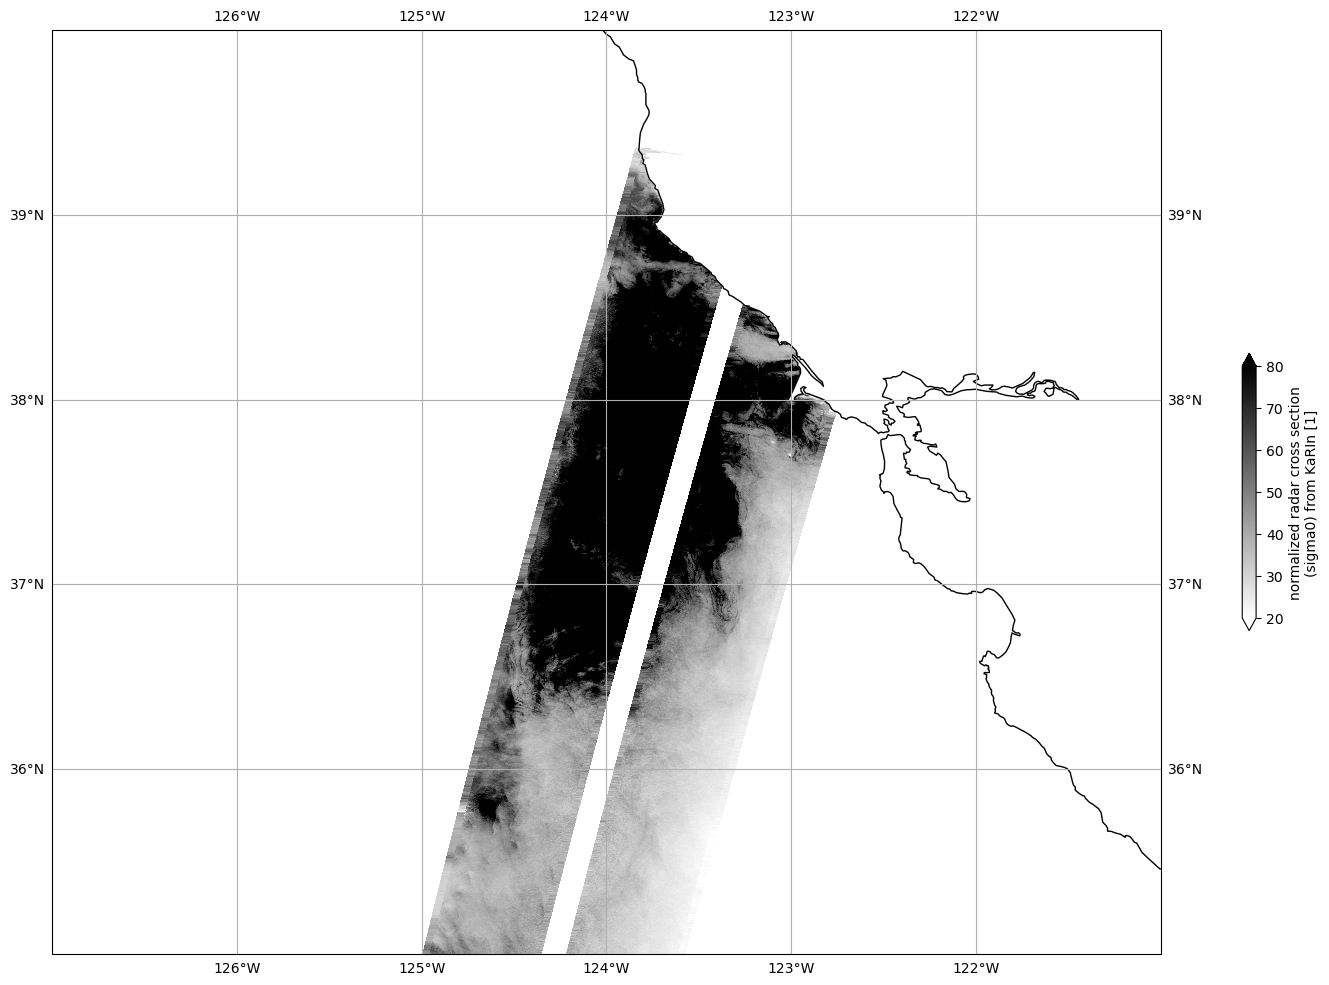

In [17]:
plot_kwargs = dict(
    x="longitude",
    y="latitude",
    cmap="gray_r",
    vmin=20,
    vmax=80,
)

fig, ax = plt.subplots(figsize=(21, 12), subplot_kw=dict(projection=ccrs.PlateCarree()))
ds_left.sig0_karin_2.plot.pcolormesh(ax=ax, cbar_kwargs={"shrink": 0.3}, **plot_kwargs)
ds_right.sig0_karin_2.plot.pcolormesh(ax=ax, add_colorbar=False, **plot_kwargs)

ax.gridlines(draw_labels=True)
ax.coastlines()
ax.set_extent([-127, -121, 35, 40], crs=ccrs.PlateCarree())

### Plot SSHA



Mask invalid data



In [18]:
for dss in ds_left, ds_right:
    dss["ssh_karin_2"] = dss.ssh_karin_2.where(dss.ancillary_surface_classification_flag==0)
    dss["ssh_karin_2"] = dss.ssh_karin_2.where(dss.ssh_karin_2_qual==0)

Plot data



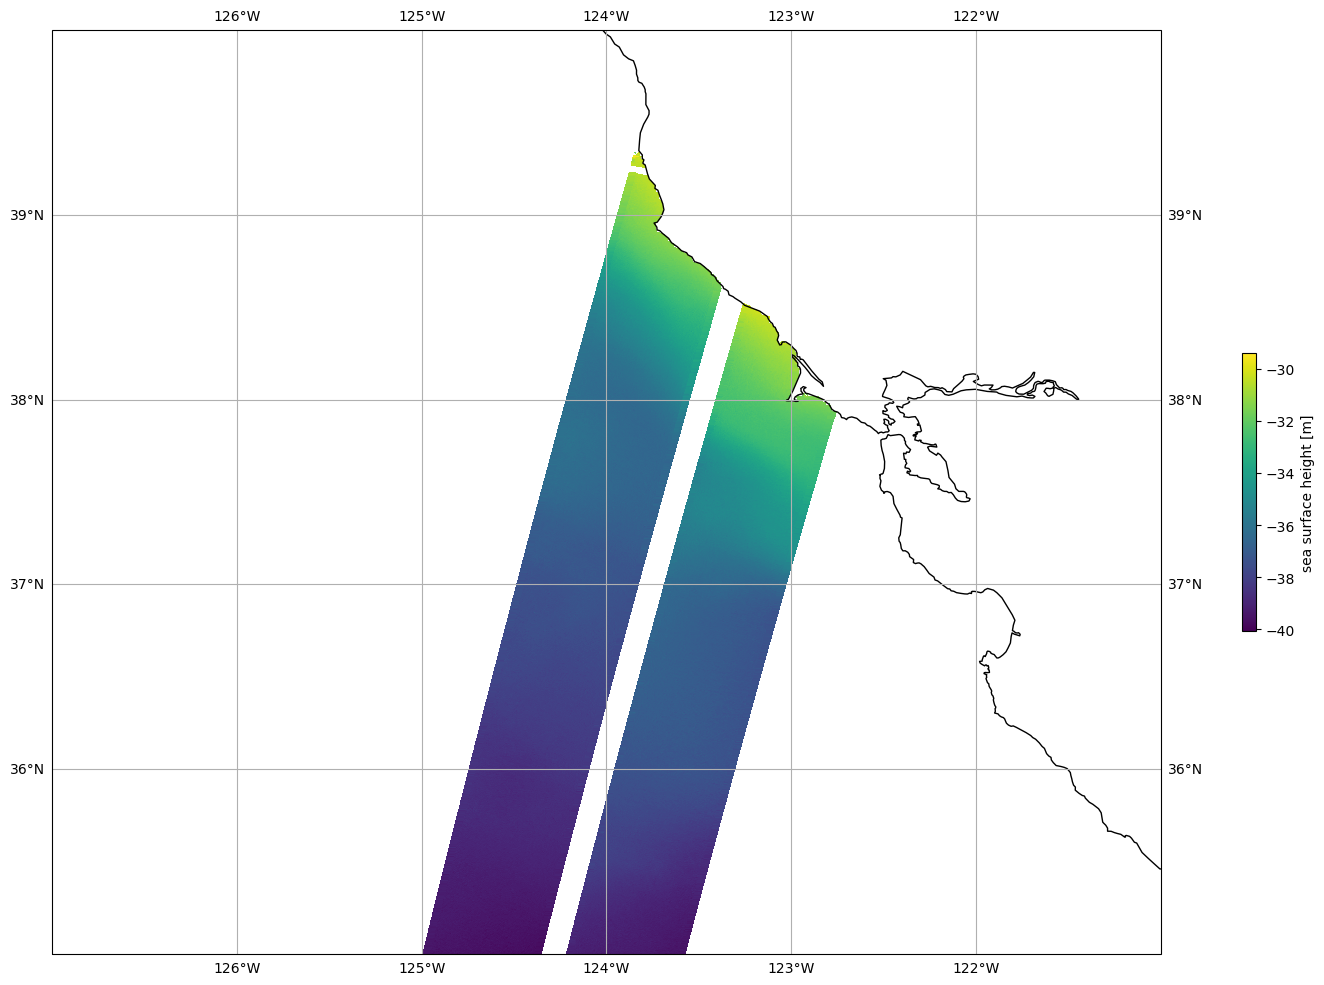

In [19]:
plot_kwargs = dict(
    x="longitude",
    y="latitude",
)

fig, ax = plt.subplots(figsize=(21, 12), subplot_kw=dict(projection=ccrs.PlateCarree()))
ds_left.ssh_karin_2.plot.pcolormesh(ax=ax, cbar_kwargs={"shrink": 0.3}, **plot_kwargs)
ds_right.ssh_karin_2.plot.pcolormesh(ax=ax, add_colorbar=False, **plot_kwargs)

ax.gridlines(draw_labels=True)
ax.coastlines()
ax.set_extent([-127, -121, 35, 40], crs=ccrs.PlateCarree())